# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [64]:
def mse(y_true: np.ndarray, y_predicted: np.ndarray):
    return (np.linalg.norm(y_true - y_predicted) ** 2) / len(y_true)

def r2(y_true: np.ndarray, y_predicted: np.ndarray):
    mean_y = np.mean(y_true)
    u = np.linalg.norm(y_predicted - y_true) ** 2
    v = np.linalg.norm(mean_y - y_true) ** 2
    return 1 - u / v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [65]:
class NormalLR:
    def __init__(self):
        self.w = None
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.copy(X)
        y = np.copy(y)
        X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        self.w = np.linalg.inv(X.transpose() @ X) @ (X.transpose() @ y)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.copy(X)
        X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        return X @ self.w

In [66]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [67]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.008395376202666067, R2: 0.9985540611236612


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [126]:
class GradientLR:
    def __init__(self, alpha: float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
        return
    
    def grad(self, w, N):
        X = self.X
        y = self.y
        return ((X.transpose() @ (X @ w - y)) / N) + self.l * np.sign(w)
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X = np.hstack((X, np.ones(X.shape[0]).reshape(-1, 1)))
        self.y = np.copy(y)
        w = np.ones(self.X.shape[1])
        d = -self.grad(w, X.shape[0])
        norm_init = np.linalg.norm(d) ** 2
        for i in range(self.iterations):
            w = w + self.alpha * d
            d = -self.grad(w, X.shape[0])
            norm_d = np.linalg.norm(d) ** 2
            if norm_d / norm_init < 1e-8:
                break
        self.w = w

    def predict(self, X: np.ndarray):
        X = np.copy(X)
        X = np.hstack((X, np.ones(X.shape[0]).reshape(-1, 1)))
        return X @ self.w

In [127]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [128]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

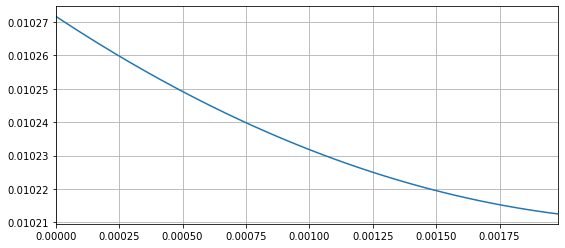

In [129]:
build_plot(X_train, y_train, X_val, y_val)

In [134]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009270474376132133, R2: 0.9985840123281513
